
## SQL exercises

### Chinook database ERD diagram

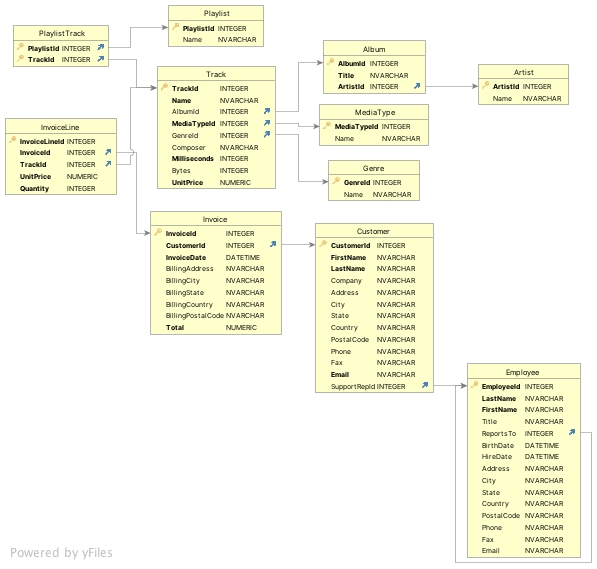


In this lecture we'll practice performing SQL queries using the Python SQLite module and the `flights` database:

In [1]:
import sqlite3

con = sqlite3.connect("flights.sqlite")
cur = con.cursor()

### The `cursor` object
The cursor object is used to perform queries and fetch results. `cur.execute(query)` will execute `query` and return a results object:

In [5]:
res = cur.execute("select * from flights limit 10")
#for row in res:
#     print(row)

(Actually, `res` is just the original cursor itself):

In [6]:
res is cur

True

### Fetching results
To retrieve results, use the `cur.fetchone()` or `cur.fetchall()` methods:

In [7]:
cur.fetchone()

(2013,
 1,
 1,
 517,
 515,
 2.0,
 830,
 819,
 11.0,
 'UA',
 1545,
 'N14228',
 'EWR',
 'IAH',
 227.0,
 1400.0,
 5.0,
 15.0,
 1357034400.0)

This returns a tuple containing one entry for each column in our `SELECT` statement.

If you want all the rows, use `cur.fetchall()`:

In [8]:
len(res.fetchall())

9

Notice that `.fetchall()` works like an iterator--we `SELECT`ed 10 rows, fetched one of them using `.fetchone()`, and then fetched the remaining 9 using `.fetchall()`. If we run this again we'll get zero rows back because we already fetched everything:

In [9]:
len(res.fetchall())

0

### Parameterized queries

Sometimes our queries must depend on user input. Consider the following query which returns all the flights that happened in a certain month:

In [10]:
def num_flights_in_month(month):
    query = f"SELECT COUNT() FROM flights WHERE month = {month}"
    return cur.execute(query).fetchone()[0]


num_flights_in_month(1)

27004

For queries that depend on a parameter, we can use the special placeholder `?` to have the database do parameter substitution for us:

In [11]:
def num_flights_in_month(m):
    query = """
        SELECT COUNT() FROM flights WHERE month = ?
    """
    return cur.execute(query, [m]).fetchone()[0]


num_flights_in_month(1)

27004

Using multiple placeholders is possible:


In [12]:
def num_flights_on_day(m, d):
    query = """SELECT COUNT() FROM flights WHERE month = ? AND day = ?"""
    return cur.execute(query, [m, d]).fetchone()[0]

num_flights_on_day(12, 25)

719

Notice that, even if there is just one parameter, you have to pass in all the parameters as a `list`.

### Why use placeholders
Consider the following table:

In [13]:
scon = sqlite3.connect(":memory:")
scon.execute(
    """
    CREATE TABLE users
    (id INTEGER PRIMARY KEY AUTOINCREMENT, username TEXT, age INT, password TEXT)
"""
)
scon.execute(
    """INSERT INTO users(username, age, password) VALUES
('John', 40, 'beeri$g00d'),
('Jane', 41, 'wat3rp0l0'),
('Julian', 20, 'il0vecr0ut0n3')
"""
)
scon.commit()

Here's our table:

In [14]:
import pandas as pd

pd.read_sql_query("SELECT * from users", scon)

,id,username,age,password
0,1,John,40,beeri$g00d
1,2,Jane,41,wat3rp0l0
2,3,Julian,20,il0vecr0ut0n3


Now let's say we have a function which takes a user-supplied parameter, their username, and returns their user information:

In [15]:
def user_info(username):
    q = f"SELECT * FROM users WHERE username = '{username}'"
    print(q)
    return pd.read_sql_query(q, scon)

user_info("John")

SELECT * FROM users WHERE username = 'John'


,id,username,age,password
0,1,John,40,beeri$g00d


This works great assuming that what got passed in is actually a username, but a malicious user could do the following:

In [16]:
user_info("xyz' or 'a'='a")

SELECT * FROM users WHERE username = 'xyz' or 'a'='a'


,id,username,age,password
0,1,John,40,beeri$g00d
1,2,Jane,41,wat3rp0l0
2,3,Julian,20,il0vecr0ut0n3


This is known as an **injection attack**. For this reason, we do not pass user input directly into a query string. Instead we use placeholders, and rely on the SQL engine itself to perform the substitution:

In [17]:
def safe_user_info(username):
    q = "SELECT * FROM users WHERE username = ?"
    print(q)
    return pd.read_sql_query(q, scon, params=[username])


safe_user_info("""abc' or 'a'='a""")

SELECT * FROM users WHERE username = ?


,id,username,age,password


In [18]:
safe_user_info("""abc' or 'a'='a""")

SELECT * FROM users WHERE username = ?


,id,username,age,password


## Ten questions about `flights`

Now we will use SQL queries to various questions about the `flights` dataset.

### Which airport is the busiest?
We need to aggregate `flights` by the `origin` column, and they count the number of rows in each group.

In [19]:
cur.execute("SELECT origin, COUNT() FROM flights GROUP BY origin").fetchall()

[('EWR', 120835), ('JFK', 111279), ('LGA', 104662)]

### Which month was coldest?
We need to aggregate `weather` by `month`, and the compute some measure of coldness.

In [20]:
cur.execute("SELECT month, AVG(temp) FROM weather GROUP BY month order by avg(temp)").fetchall()

[(2, 34.27059701492533),
 (1, 35.63566037735852),
 (12, 38.44180037313427),
 (3, 39.880071845532164),
 (11, 44.9904343764596),
 (4, 51.745641500694774),
 (10, 60.07113019891505),
 (5, 61.79500000000004),
 (9, 67.3712922649374),
 (6, 72.18399999999997),
 (8, 74.4684657039714),
 (7, 80.06622082585272)]

### What is the most popular carrier at each of the three NYC airports?
This one is a bit trickier. We start by counting the number of flights for each combination of `carrier` and `origin`:

In [23]:
cur.execute("SELECT COUNT(), carrier, origin FROM flights GROUP BY origin, carrier order by  count() desc").fetchall()

[(46087, 'UA', 'EWR'),
 (43939, 'EV', 'EWR'),
 (42076, 'B6', 'JFK'),
 (23067, 'DL', 'LGA'),
 (20701, 'DL', 'JFK'),
 (16928, 'MQ', 'LGA'),
 (15459, 'AA', 'LGA'),
 (14651, '9E', 'JFK'),
 (13783, 'AA', 'JFK'),
 (13136, 'US', 'LGA'),
 (8826, 'EV', 'LGA'),
 (8044, 'UA', 'LGA'),
 (7193, 'MQ', 'JFK'),
 (6557, 'B6', 'EWR'),
 (6188, 'WN', 'EWR'),
 (6087, 'WN', 'LGA'),
 (6002, 'B6', 'LGA'),
 (4534, 'UA', 'JFK'),
 (4405, 'US', 'EWR'),
 (4342, 'DL', 'EWR'),
 (3596, 'VX', 'JFK'),
 (3487, 'AA', 'EWR'),
 (3260, 'FL', 'LGA'),
 (2995, 'US', 'JFK'),
 (2541, '9E', 'LGA'),
 (2276, 'MQ', 'EWR'),
 (1566, 'VX', 'EWR'),
 (1408, 'EV', 'JFK'),
 (1268, '9E', 'EWR'),
 (714, 'AS', 'EWR'),
 (685, 'F9', 'LGA'),
 (601, 'YV', 'LGA'),
 (342, 'HA', 'JFK'),
 (26, 'OO', 'LGA'),
 (6, 'OO', 'EWR')]

In [24]:
cur.execute("SELECT COUNT(), carrier, origin FROM flights GROUP BY carrier, origin order by origin, count() desc").fetchall()

[(46087, 'UA', 'EWR'),
 (43939, 'EV', 'EWR'),
 (6557, 'B6', 'EWR'),
 (6188, 'WN', 'EWR'),
 (4405, 'US', 'EWR'),
 (4342, 'DL', 'EWR'),
 (3487, 'AA', 'EWR'),
 (2276, 'MQ', 'EWR'),
 (1566, 'VX', 'EWR'),
 (1268, '9E', 'EWR'),
 (714, 'AS', 'EWR'),
 (6, 'OO', 'EWR'),
 (42076, 'B6', 'JFK'),
 (20701, 'DL', 'JFK'),
 (14651, '9E', 'JFK'),
 (13783, 'AA', 'JFK'),
 (7193, 'MQ', 'JFK'),
 (4534, 'UA', 'JFK'),
 (3596, 'VX', 'JFK'),
 (2995, 'US', 'JFK'),
 (1408, 'EV', 'JFK'),
 (342, 'HA', 'JFK'),
 (23067, 'DL', 'LGA'),
 (16928, 'MQ', 'LGA'),
 (15459, 'AA', 'LGA'),
 (13136, 'US', 'LGA'),
 (8826, 'EV', 'LGA'),
 (8044, 'UA', 'LGA'),
 (6087, 'WN', 'LGA'),
 (6002, 'B6', 'LGA'),
 (3260, 'FL', 'LGA'),
 (2541, '9E', 'LGA'),
 (685, 'F9', 'LGA'),
 (601, 'YV', 'LGA'),
 (26, 'OO', 'LGA')]

Next, we need to rank the carriers within origin by their counts. Notice this is using a subquery to get the result

```SELECT * FROM (<another query>)```

In [25]:
cur.execute(
    """
    SELECT RANK() OVER (
        PARTITION BY origin
        ORDER BY n desc
    ) AS r, carrier, origin, n FROM
    (SELECT COUNT() as n, carrier, origin FROM flights GROUP BY carrier, origin)
"""
).fetchall()

[(1, 'UA', 'EWR', 46087),
 (2, 'EV', 'EWR', 43939),
 (3, 'B6', 'EWR', 6557),
 (4, 'WN', 'EWR', 6188),
 (5, 'US', 'EWR', 4405),
 (6, 'DL', 'EWR', 4342),
 (7, 'AA', 'EWR', 3487),
 (8, 'MQ', 'EWR', 2276),
 (9, 'VX', 'EWR', 1566),
 (10, '9E', 'EWR', 1268),
 (11, 'AS', 'EWR', 714),
 (12, 'OO', 'EWR', 6),
 (1, 'B6', 'JFK', 42076),
 (2, 'DL', 'JFK', 20701),
 (3, '9E', 'JFK', 14651),
 (4, 'AA', 'JFK', 13783),
 (5, 'MQ', 'JFK', 7193),
 (6, 'UA', 'JFK', 4534),
 (7, 'VX', 'JFK', 3596),
 (8, 'US', 'JFK', 2995),
 (9, 'EV', 'JFK', 1408),
 (10, 'HA', 'JFK', 342),
 (1, 'DL', 'LGA', 23067),
 (2, 'MQ', 'LGA', 16928),
 (3, 'AA', 'LGA', 15459),
 (4, 'US', 'LGA', 13136),
 (5, 'EV', 'LGA', 8826),
 (6, 'UA', 'LGA', 8044),
 (7, 'WN', 'LGA', 6087),
 (8, 'B6', 'LGA', 6002),
 (9, 'FL', 'LGA', 3260),
 (10, '9E', 'LGA', 2541),
 (11, 'F9', 'LGA', 685),
 (12, 'YV', 'LGA', 601),
 (13, 'OO', 'LGA', 26)]

Finally, to find the most popular carriers, we can filter this table to only the rows where `rank=1`. To do this I will extend the query with the 'where' clause


In [26]:
cur.execute("""
    SELECT * FROM (SELECT RANK() OVER (
        PARTITION BY origin
        ORDER BY n DESC
    ) AS r, carrier, origin, n FROM
    (SELECT COUNT() as n, carrier, origin FROM flights GROUP BY carrier, origin)
    ) WHERE r = 1
""").fetchall()

[(1, 'UA', 'EWR', 46087), (1, 'B6', 'JFK', 42076), (1, 'DL', 'LGA', 23067)]

### What are the busiest travel weeks of the year?
We need to figure out the week of each flight, and then aggregate them. To manipulate dates in sqlite, we have the [`strftime()` function](https://www.sqlite.org/lang_datefunc.html):

In [27]:
cur.execute("""SELECT strftime('%M', 'now')""").fetchone()

('45',)

### The Unix epoch
The `time_hour` column in `flights` looks like:

In [28]:
cur.execute("""SELECT time_hour FROM flights""").fetchone()

(1357034400.0,)

This number represents the number of seconds that have elapsed since midnight GMT on January 1, 1970, a date known as the [Unix epoch](https://en.wikipedia.org/wiki/Unix_time). We can use `strftime()` on these dates provided we tell it how they are formatted.

In [29]:
# datetime() is an alias for strftime('%Y-%m-%d %H:%M:%S', ...)
cur.execute("""SELECT datetime(1357034400, 'unixepoch')""").fetchone()

('2013-01-01 10:00:00',)

Now we can convert each date to a week of the year:

In [30]:
pd.read_sql_query(
    """
    SELECT year, month, day, strftime('%W', time_hour, 'unixepoch') as week
from flights""",
    con,
)

,year,month,day,week
0,2013,1,1,00
1,2013,1,1,00
2,2013,1,1,00
3,2013,1,1,00
4,2013,1,1,00
...,...,...,...,...
336771,2013,9,30,39
336772,2013,9,30,39
336773,2013,9,30,39
336774,2013,9,30,39


The final query looks like:

In [31]:
con.execute(
    """
    SELECT COUNT() as n, strftime('%W', time_hour, 'unixepoch') as week FROM flights
    GROUP BY week
    ORDER BY n DESC
    LIMIT 5
"""
).fetchall()

[(6760, '27'), (6740, '29'), (6737, '28'), (6735, '30'), (6733, '31')]

### What were the ten worst days for average departure delay?

In [32]:
con.execute('''SELECT year, month, day, AVG(dep_delay) AS avg_delay
            FROM flights GROUP BY year, month, day
            ORDER BY avg_delay DESC
            LIMIT 10''').fetchall()

[(2013, 3, 8, 83.5369211514393),
 (2013, 7, 1, 56.23382519863791),
 (2013, 9, 2, 53.029550827423165),
 (2013, 7, 10, 52.860702151755376),
 (2013, 12, 5, 52.32799013563502),
 (2013, 5, 23, 51.14471968709257),
 (2013, 9, 12, 49.95875),
 (2013, 6, 28, 48.827784156142364),
 (2013, 6, 24, 47.15741789354473),
 (2013, 7, 22, 46.66704675028506)]

### What were the ten best days for departure delay?

In [33]:
con.execute('''SELECT year, month, day, AVG(dep_delay) AS avg_delay
            FROM flights GROUP BY year, month, day
            ORDER BY avg_delay ASC
            LIMIT 10''').fetchall()

[(2013, 9, 24, -1.3298319327731092),
 (2013, 10, 2, -0.919917864476386),
 (2013, 11, 9, -0.6288515406162465),
 (2013, 9, 6, -0.39792746113989635),
 (2013, 9, 5, -0.3877973112719752),
 (2013, 10, 29, -0.34932221063607927),
 (2013, 9, 7, -0.25036390101892286),
 (2013, 11, 5, -0.18314255983350677),
 (2013, 10, 19, -0.10703812316715543),
 (2013, 10, 1, -0.09895833333333333)]

### What airlines have the most departure delay?

In [34]:
con.execute('''SELECT airlines.carrier, name, AVG(dep_delay) AS avg_delay
            FROM flights
            JOIN airlines on airlines.carrier=flights.carrier
            GROUP BY airlines.name
            ORDER BY avg_delay DESC
            LIMIT 10''').fetchall()

[('F9', 'Frontier Airlines Inc.', 20.215542521994134),
 ('EV', 'ExpressJet Airlines Inc.', 19.955389827868213),
 ('YV', 'Mesa Airlines Inc.', 18.996330275229358),
 ('FL', 'AirTran Airways Corporation', 18.72607467838092),
 ('WN', 'Southwest Airlines Co.', 17.71174377224199),
 ('9E', 'Endeavor Air Inc.', 16.725769407441433),
 ('B6', 'JetBlue Airways', 13.022522106740018),
 ('VX', 'Virgin America', 12.869421165464821),
 ('OO', 'SkyWest Airlines Inc.', 12.586206896551724),
 ('UA', 'United Air Lines Inc.', 12.106072888459614)]

## Using *Having* clause
Which airlines have average departure delays between 5-10 minutes?

In [ ]:
con.execute('''SELECT airlines.carrier, name, AVG(dep_delay) AS avg_delay
            FROM flights
            JOIN airlines on airlines.carrier=flights.carrier
            GROUP BY airlines.name
            HAVING avg_delay between 5 and 10''').fetchall()

[('AS', 'Alaska Airlines Inc.', 5.804775280898877),
 ('AA', 'American Airlines Inc.', 8.586015642040321),
 ('DL', 'Delta Air Lines Inc.', 9.26450451204958)]

### What airplane flew the most days?
Airplanes are identified by their tail number.

In [ ]:
cur.execute('''SELECT tailnum, COUNT() AS n FROM
    (SELECT DISTINCT year, month, day, tailnum FROM flights)
    GROUP BY tailnum
    ORDER BY n DESC
    LIMIT 1
''').fetchall()

[('N328AA', 336)]

Interestingly, you can Google most tail numbers: [N328AA](https://www.planespotters.net/airframe/boeing-767-200-n328aa-american-airlines/enj523).

### How many flights were cancelled?
We'll say that a cancelled flight has `dep_time` missing.

In [ ]:
cur.execute('''SELECT COUNT() FROM flights WHERE dep_time IS NULL''').fetchone()

(8255,)

Notice that we don't write `= NULL`. That does not work:

In [ ]:
cur.execute('''SELECT COUNT() FROM flights WHERE dep_time = NULL''').fetchone()

(0,)

### How many flights were destined for airports with a one word name?

(Not including the word "airport")

Here is an example of an airport with a one-word name:

In [ ]:
cur.execute("SELECT * FROM airports WHERE name = 'Packwood'").description

(('faa', None, None, None, None, None, None),
 ('name', None, None, None, None, None, None),
 ('lat', None, None, None, None, None, None),
 ('lon', None, None, None, None, None, None),
 ('alt', None, None, None, None, None, None),
 ('tz', None, None, None, None, None, None),
 ('dst', None, None, None, None, None, None),
 ('tzone', None, None, None, None, None, None))

In [ ]:
cur.execute("SELECT faa, name FROM airports WHERE name NOT LIKE '% %'").fetchall()

[('55S', 'Packwood'),
 ('6S2', 'Florence'),
 ('ACV', 'Arcata'),
 ('ADQ', 'Kodiak'),
 ('ADS', 'Addison'),
 ('ALX', 'Alexandria'),
 ('APA', 'Centennial'),
 ('ARV', 'Lakeland'),
 ('ATW', 'Appleton'),
 ('AVO', 'Executive'),
 ('AVX', 'Avalon'),
 ('AZO', 'Kalamazoo'),
 ('BET', 'Bethel'),
 ('BFT', 'Beaufort'),
 ('BTT', 'Bettles'),
 ('BWD', 'KBWD'),
 ('CDK', 'CedarKey'),
 ('CEU', 'Clemson'),
 ('CHO', 'Charlottesville-Albemarle'),
 ('CLS', 'Chehalis-Centralia'),
 ('CMI', 'Champaign'),
 ('CRW', 'Yeager'),
 ('CZG', 'Tri-Cities'),
 ('DEC', 'Decatur'),
 ('DLG', 'Dillingham'),
 ('DPA', 'Dupage'),
 ('DTS', 'Destin'),
 ('DUT', 'Unalaska'),
 ('DWS', 'Orlando'),
 ('EKY', 'Bessemer'),
 ('ENV', 'Wendover'),
 ('FKL', 'Franklin'),
 ('FME', 'Tipton'),
 ('GKN', 'Gulkana'),
 ('GPT', 'Gulfport-Biloxi'),
 ('GVT', 'Majors'),
 ('HDH', 'Dillingham'),
 ('HNM', 'Hana'),
 ('HOM', 'Homer'),
 ('ILI', 'Iliamna'),
 ('IMM', 'Immokalee'),
 ('JHM', 'Kapalua'),
 ('LGU', 'Logan-Cache'),
 ('LIH', 'Lihue'),
 ('LNK', 'Lincoln'),


In [ ]:
cur.execute(
    """
    SELECT COUNT() FROM flights
    INNER JOIN (SELECT faa FROM airports WHERE name NOT LIKE '% %') one_word
    ON one_word.faa = flights.dest
    """
).fetchall()

[(190,)]